In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
from agae import *
from utils import *

In [3]:

device = get_default_device()
print(torch.__version__)  #注意是双下划线
print(device)

1.13.1+cu117
cuda


### 处理正常数据

In [4]:
#Read data
normal = pd.read_csv("input/SWaT_Dataset_Normal.csv", header=0)#, nrows=1000)
print(normal.head())
print(normal.columns)

                Timestamp    FIT101    LIT101  MV101  P101  P102    AIT201  \
0   22/12/2015 4:00:00 PM  2.470294  261.5804      2     2     1  244.3284   
1   22/12/2015 4:00:01 PM  2.457163  261.1879      2     2     1  244.3284   
2   22/12/2015 4:00:02 PM  2.439548  260.9131      2     2     1  244.3284   
3   22/12/2015 4:00:03 PM  2.428338  260.2850      2     2     1  244.3284   
4   22/12/2015 4:00:04 PM  2.424815  259.8925      2     2     1  244.4245   

    AIT202   AIT203    FIT201  ...  P501  P502    PIT501  PIT502    PIT503  \
0  8.19008  306.101  2.471278  ...     1     1  10.02948     0.0  4.277749   
1  8.19008  306.101  2.468587  ...     1     1  10.02948     0.0  4.277749   
2  8.19008  306.101  2.467305  ...     1     1  10.02948     0.0  4.277749   
3  8.19008  306.101  2.466536  ...     1     1  10.02948     0.0  4.277749   
4  8.19008  306.101  2.466536  ...     1     1  10.02948     0.0  4.277749   

     FIT601  P601  P602  P603  Normal/Attack  
0  0.000256    

In [5]:
normal = normal.drop(["Timestamp" , "Normal/Attack" ] , axis = 1)
normal.shape
print(normal.head())

     FIT101    LIT101  MV101  P101  P102    AIT201   AIT202   AIT203  \
0  2.470294  261.5804      2     2     1  244.3284  8.19008  306.101   
1  2.457163  261.1879      2     2     1  244.3284  8.19008  306.101   
2  2.439548  260.9131      2     2     1  244.3284  8.19008  306.101   
3  2.428338  260.2850      2     2     1  244.3284  8.19008  306.101   
4  2.424815  259.8925      2     2     1  244.4245  8.19008  306.101   

     FIT201  MV201  ...  FIT504  P501  P502    PIT501  PIT502    PIT503  \
0  2.471278      2  ...     0.0     1     1  10.02948     0.0  4.277749   
1  2.468587      2  ...     0.0     1     1  10.02948     0.0  4.277749   
2  2.467305      2  ...     0.0     1     1  10.02948     0.0  4.277749   
3  2.466536      2  ...     0.0     1     1  10.02948     0.0  4.277749   
4  2.466536      2  ...     0.0     1     1  10.02948     0.0  4.277749   

     FIT601  P601  P602  P603  
0  0.000256     1     1     1  
1  0.000256     1     1     1  
2  0.000256     1   

In [6]:
# Transform all columns into float64
normal = normal.astype(float)

In [7]:
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()

x = normal.values
x_scaled = min_max_scaler.fit_transform(x)
normal = pd.DataFrame(x_scaled)

In [8]:
normal.head(2)

,0,1,2,3,4,5,6,7,8,9,...,41,42,43,44,45,46,47,48,49,50
0,0.899895,0.160292,1.0,1.0,0.0,0.0,0.0,0.01971,0.993304,1.0,...,0.0,0.0,0.0,0.004448,0.0,0.005921,0.000147,0.0,0.0,0.0
1,0.895111,0.159845,1.0,1.0,0.0,0.0,0.0,0.01971,0.992222,1.0,...,0.0,0.0,0.0,0.004448,0.0,0.005921,0.000147,0.0,0.0,0.0


### 处理攻击数据

In [9]:
#Read data
attack = pd.read_csv("input/SWaT_Dataset_Attack.csv",header=0)#, nrows=1000)
print(normal.columns)
labels = [ float(label!= 'Normal' ) for label  in attack["Normal/Attack"].values] #等于normal就是0，异常就是1
attack = attack.drop(["Timestamp" , "Normal/Attack" ] , axis = 1)
print("测试数据集形状：{}，标签长度：{}".format(attack.shape, len(labels)))

RangeIndex(start=0, stop=51, step=1)
测试数据集形状：(449919, 51)，标签长度：449919


In [10]:
# Transform all columns into float64
attack = attack.astype(float)
x2 = attack.values
x_scaled2 = min_max_scaler.fit_transform(x2)
attack = pd.DataFrame(x_scaled2)

In [11]:
attack.head(2)

,0,1,2,3,4,5,6,7,8,9,...,41,42,43,44,45,46,47,48,49,50
0,0.879322,0.452962,1.0,1.0,0.0,0.942783,0.876785,0.436773,0.865044,1.0,...,0.987464,1.0,0.0,0.985802,0.837398,0.987359,0.000071,0.0,0.0,0.0
1,0.886285,0.453015,1.0,1.0,0.0,0.942783,0.876785,0.436773,0.865044,1.0,...,0.987464,1.0,0.0,0.985802,0.837398,0.987783,0.000071,0.0,0.0,0.0


In [12]:
print(normal.shape)
window_size = 12
windows_normal=normal.values[np.arange(window_size)[None, :] + np.arange(normal.shape[0]-window_size)[:, None]] #窗口化处理
windows_normal.shape

(496800, 51)


(496788, 12, 51)

In [13]:
windows_attack=attack.values[np.arange(window_size)[None, :] + np.arange(attack.shape[0]-window_size)[:, None]]
windows_attack.shape

(449907, 12, 51)

In [14]:
## Training

In [40]:
import torch.utils.data as data_utils

BATCH_SIZE =  7000
N_EPOCHS = 100
hidden_size = 200

In [41]:
w_size=windows_normal.shape[1]*windows_normal.shape[2]
z_size=hidden_size
windows_normal_train = windows_normal[:int(np.floor(.8 *  windows_normal.shape[0]))]
windows_normal_val = windows_normal[int(np.floor(.8 *  windows_normal.shape[0])):int(np.floor(windows_normal.shape[0]))]
print("输入层维度：{}， 潜空间维度：{}，训练数据集：{}，验证数据集：{}".format(w_size, z_size, windows_normal_train.shape, windows_normal_val.shape))

输入层维度：612， 潜空间维度：200，训练数据集：(397430, 12, 51)，验证数据集：(99358, 12, 51)


In [42]:
train_loader = torch.utils.data.DataLoader(data_utils.TensorDataset(
    torch.from_numpy(windows_normal_train).float().view(([windows_normal_train.shape[0],w_size]))
) , batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

val_loader = torch.utils.data.DataLoader(data_utils.TensorDataset(
    torch.from_numpy(windows_normal_val).float().view(([windows_normal_val.shape[0],w_size]))
) , batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
test_loader = torch.utils.data.DataLoader(data_utils.TensorDataset(
    torch.from_numpy(windows_attack).float().view(([windows_attack.shape[0],w_size]))
) , batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
model = AGAEModel(w_size, z_size)
model = to_device(model,device)

In [43]:
history = training(N_EPOCHS,model,train_loader,val_loader)

Epoch [0], 训练耗时：4.29s, val_loss1: 0.0249, val_loss2: 0.0248
Epoch [1], 训练耗时：3.75s, val_loss1: 0.0266, val_loss2: -0.0030
Epoch [2], 训练耗时：4.11s, val_loss1: 0.0268, val_loss2: -0.0111
Epoch [3], 训练耗时：3.97s, val_loss1: 0.0274, val_loss2: -0.0156
Epoch [4], 训练耗时：3.95s, val_loss1: 0.0277, val_loss2: -0.0181
Epoch [5], 训练耗时：3.87s, val_loss1: 0.0280, val_loss2: -0.0200
Epoch [6], 训练耗时：3.84s, val_loss1: 0.0288, val_loss2: -0.0217
Epoch [7], 训练耗时：4.13s, val_loss1: 0.0295, val_loss2: -0.0232
Epoch [8], 训练耗时：4.07s, val_loss1: 0.0289, val_loss2: -0.0234
Epoch [9], 训练耗时：3.94s, val_loss1: 0.0289, val_loss2: -0.0240
Epoch [10], 训练耗时：4.41s, val_loss1: 0.0300, val_loss2: -0.0254
Epoch [11], 训练耗时：4.10s, val_loss1: 0.0293, val_loss2: -0.0251
Epoch [12], 训练耗时：3.80s, val_loss1: 0.0292, val_loss2: -0.0253
Epoch [13], 训练耗时：4.04s, val_loss1: 0.0298, val_loss2: -0.0261
Epoch [14], 训练耗时：4.14s, val_loss1: 0.0291, val_loss2: -0.0257
Epoch [15], 训练耗时：3.91s, val_loss1: 0.0299, val_loss2: -0.0267
Epoch [16], 训练耗时：3.

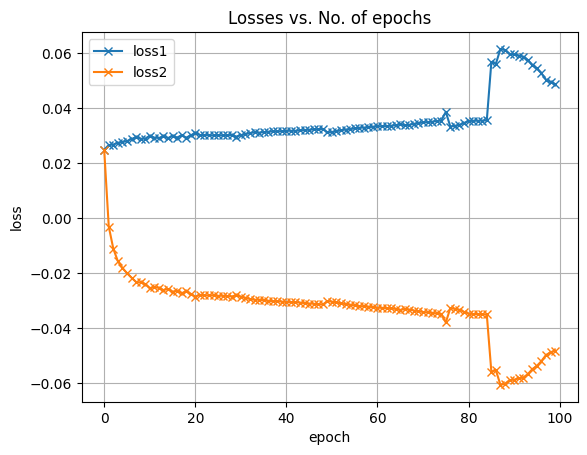

In [46]:
plot_history(history)

In [47]:
torch.save({
            'encoder': model.encoder.state_dict(),
            'decoder1': model.decoder1.state_dict(),
            'decoder2': model.decoder2.state_dict()
            }, "model.pth")

## Testing

In [48]:
checkpoint = torch.load("model.pth")
model.encoder.load_state_dict(checkpoint['encoder'])
model.decoder1.load_state_dict(checkpoint['decoder1'])
model.decoder2.load_state_dict(checkpoint['decoder2'])

<All keys matched successfully>

In [49]:
ts=testing(model,val_loader)
tp=np.concatenate([torch.stack(ts[:-1]).flatten().detach().cpu().numpy(),
                              ts[-1].flatten().detach().cpu().numpy()])
maxT=np.max(tp)
minT=np.min(tp)
print("最大阈值：{}，最小阈值：{}".format(maxT,minT))

最大阈值：0.02420607954263687，最小阈值：-0.14347247779369354


In [52]:
#测试集测试，并展开成数组
results=testing(model,test_loader)
y_pred=np.concatenate([torch.stack(results[:-1]).flatten().detach().cpu().numpy(),
                              results[-1].flatten().detach().cpu().numpy()])
for i in range(len(y_pred)):
    y_pred[i] = 1 if (y_pred[i] > maxT or y_pred[i] < minT) else 0
print(sum(y_pred))

41000.0


In [54]:
#标签窗口化
windows_labels=[]
for i in range(len(labels)-window_size):
    windows_labels.append(list(np.int_(labels[i:i+window_size])))
#以窗口为单位设置异常
y_test = [1.0 if (np.sum(window) > 0) else 0 for window in windows_labels ]
print(sum(y_test))

55006.0


In [ ]:
f1 = f1_score(y_true, y_pred)
print("F1 Score:", f1)

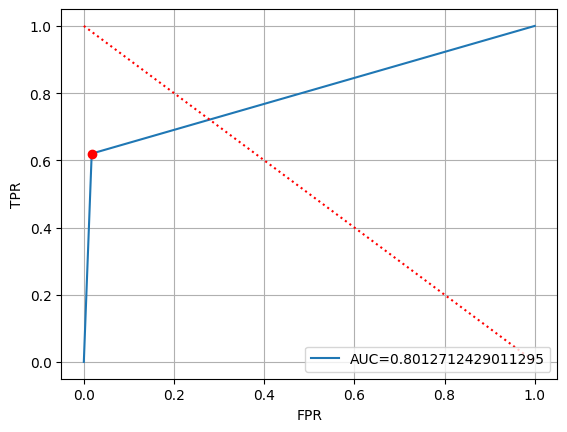

In [55]:
threshold=ROC(y_test,y_pred)